In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)
import joypy


In [449]:
##ran sequencing depth.py for all three species

In [2]:
species_list = ['human','mouse','drosophila',]

In [3]:
df_list = []
for species in species_list: 
    df_seq_depth = pd.read_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_intra.txt', sep='\t')
    df_seq_depth['species'] = species
    df_seq_depth.groupby(['proj_id'])['counts_intra'].sum().reset_index().sort_values(by='counts_intra', ascending=False).to_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_intra_ordered.txt', index=False, sep='\t', header=None)

    df_list.append(df_seq_depth)
    
    

In [4]:

df_intra = pd.concat(df_list)
df_intra =df_intra.groupby(['species', 'proj_id', 'srx_id', 'run_id'])['counts_intra'].sum().reset_index()
df_intra['counts_intra_log'] = [np.log(x) for x in df_intra['counts_intra']]



In [5]:
df_intra

species    proj_id      srx_id       run_id  counts_intra  \
0      drosophila  ERP016479  ERX1973293   ERR1912865       5849651   
1      drosophila  ERP016479  ERX1973293   ERR1912866      56960473   
2      drosophila  ERP016479  ERX1973293   ERR1912867      51619773   
3      drosophila  ERP016479  ERX1973294   ERR1912868       2215043   
4      drosophila  ERP016479  ERX1973294   ERR1912869      36483414   
...           ...        ...         ...          ...           ...   
10833       mouse  SRP292639  SRX9533664  SRR13087451        474163   
10834       mouse  SRP292639  SRX9533665  SRR13087450        591452   
10835       mouse  SRP292639  SRX9533666  SRR13087449        603787   
10836       mouse  SRP292639  SRX9533667  SRR13087448        477567   
10837       mouse  SRP292639  SRX9533668  SRR13087447        252411   

       counts_intra_log  
0             15.581893  
1             17.857868  
2             17.759415  
3             14.610782  
4             17.412368  
...                 ...  
10833         13.069306  
10834         13.290336  
10835         13.310977  
10836         13.076460  
10837         12.438814  

[10838 rows x 6 columns]

In [929]:
df_intra.groupby('species')['proj_id'].nunique()

species
drosophila     29
human         119
mouse          33
Name: proj_id, dtype: int64

In [6]:
df_list = []
for species in species_list: 
    df_seq_depth = pd.read_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter.txt', sep='\t')
    df_seq_depth['species'] = species
    df_seq_depth.groupby(['proj_id'])['counts_inter'].sum().reset_index().sort_values(by='counts_inter', ascending=False).to_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter_ordered.txt', index=False, sep='\t', header=None)

    df_list.append(df_seq_depth)
    
    

In [7]:
df_inter = pd.concat(df_list)

In [8]:
df_intra['counts'] = df_intra['counts_intra']
df_intra['type'] = 'cis'
df_inter['counts'] = df_inter['counts_inter']
df_inter['type'] = 'trans'

In [9]:
df_all_counts_cis_vs_trans = df_intra.merge(df_inter, on=['proj_id', 'species'])

In [11]:
df_all_counts = pd.concat([df_intra, df_inter])

In [12]:
df_all_counts['counts_log'] = [np.log10(x) for x in df_all_counts['counts'] ]

In [13]:
df_all_counts_projects = df_all_counts.groupby(['species', 'proj_id', 'type'])['counts'].sum().reset_index()


In [14]:
df_all_counts_projects

species    proj_id   type      counts
0    drosophila  ERP016479    cis  1095110139
1    drosophila  ERP016479  trans   120698212
2    drosophila  ERP112723    cis    52975100
3    drosophila  ERP112723  trans    27869300
4    drosophila  ERP112882    cis   325091050
..          ...        ...    ...         ...
357       mouse  SRP268173  trans   581117420
358       mouse  SRP270993    cis  1714817107
359       mouse  SRP270993  trans   561311230
360       mouse  SRP292639    cis   523143850
361       mouse  SRP292639  trans    75510394

[362 rows x 4 columns]

In [15]:
df_all_counts_projects['counts_log'] = [np.log10(x) for x in df_all_counts_projects['counts'] ]


In [138]:
df_all_counts_projects_meta = df_all_counts_projects.groupby(['species', 'type'])['counts'].sum().reset_index()
df_all_counts_projects_meta['counts_log'] = [np.log10(x) for x in df_all_counts_projects_meta['counts'] ]

df_all_counts_projects_meta['species_dig'] = [0 if x=='human' else 1 if x=='mouse' else 2 for x in df_all_counts_projects_meta['species']]



df_all_counts_projects_meta.sort_values(['species_dig'], inplace=True)

In [139]:
df_all_counts_projects_meta

species   type        counts  counts_log  species_dig
2       human    cis  208492043801   11.319089            0
3       human  trans   96455324722   10.984326            0
4       mouse    cis  108163074666   11.034079            1
5       mouse  trans   85411419194   10.931516            1
0  drosophila    cis   16618040587   10.220580            2
1  drosophila  trans    2739466826    9.437666            2

In [24]:

def get_chrom_sizes(chroms, chrom_list):
    chrom_sizes = []
#    chrom_sizes = {}
    total_genome_length = []
    with open(chroms, 'r') as f:
        for line in f:
            values = line.split('\t')
            if values[0] in chrom_list:
                chrom_sizes.append(int(values[1]) * int(values[1])) 
                total_genome_length.append(int(values[1]))
                #chrom_sizes[values[0]] = int(values[1])
    return(sum(chrom_sizes), (sum(total_genome_length) * sum(total_genome_length)) - sum(chrom_sizes))
    #return chrom_sizes

species_total_contacts = {}
for species,  chrom_sizes, chrom_list in zip(['human', 'mouse', 'drosophila'], ['homo_sapiens_38/hg38.chrom.sizes', 'mus_musculus_10/mm10.chrom.sizes', 'drosophila_melanogaster_6/dm6.chrom.sizes'], [['chr' + str(x) for x in range(1,23)], ['chr' + str(x) for x in range(1,20)], ['chr3R','chr3L','chr2R','chr2L','chr4']]):
        cis_contacts_genome, trans_contacts_genome = get_chrom_sizes(f'/grid/gillis/data/nfox/genomes/{chrom_sizes}', chrom_list)
        #cis_contacts_genome = get_chrom_sizes(f'/grid/gillis/data/nfox/genomes/{chrom_sizes}', chrom_list)
        #print (dict(sorted(cis_contacts_genome.items(), key=lambda item: item[1])))
        species_total_contacts[species] =  cis_contacts_genome, trans_contacts_genome





In [25]:
species_total_contacts

{'human': (446638304655677934, 7818995446846638550),
 'mouse': (338390139063593401, 5726724633169315728),
 'drosophila': (3013409580879291, 9161139031046278)}

In [26]:
cis_trans_ratio_list = {}
cis_trans_ratio_list["0"] = [species_total_contacts['human'][1]/species_total_contacts['human'][0]]
cis_trans_ratio_list["1"] = [species_total_contacts['mouse'][1]/species_total_contacts['mouse'][0]]
cis_trans_ratio_list["2"] = [species_total_contacts['drosophila'][1]/species_total_contacts['drosophila'][0]]


In [27]:
cis_trans_ratio_list

{'0': [17.506325286798795],
 '1': [16.923438280490487],
 '2': [3.0401240804355325]}

In [28]:
pd.DataFrame.from_dict(cis_trans_ratio_list)

0          1         2
0  17.506325  16.923438  3.040124

<AxesSubplot:>

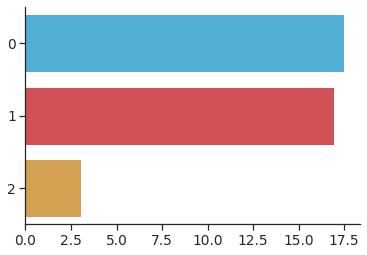

In [29]:
sns.barplot(data=pd.DataFrame.from_dict(cis_trans_ratio_list), orient='h', palette=['#3CB7E8', '#E83B43', '#E8A63B'])


In [30]:
df1 = pd.DataFrame(species_total_contacts, index=['cis', 'trans'])

In [31]:
df1.reset_index(inplace=True)

In [32]:
df1['species'] = 0

In [33]:
df1 = pd.melt(df1, id_vars=['species', 'index'])

In [34]:
df1 = df1.drop(['species'], axis=1)

In [35]:
df1 = df1.rename(columns={"index": "type", "variable": "species", "value":"genome_volume"})

In [36]:
df_all_counts_projects = df_all_counts_projects.merge(df1)

In [66]:
df_all_counts_projects['genome_density'] = df_all_counts_projects['counts'] / df_all_counts_projects['genome_volume']

df_all_counts_projects['genome_density_log'] = [np.log10((x)) for x in df_all_counts_projects['genome_density'] ]



In [141]:
df_all_counts_projects_meta = df_all_counts_projects_meta.merge(df1)
df_all_counts_projects_meta['genome_density'] = df_all_counts_projects_meta['counts'] / df_all_counts_projects_meta['genome_volume']

df_all_counts_projects_meta['genome_density_log'] = [np.log10(x) for x in df_all_counts_projects_meta['genome_density'] ]


In [184]:
df_all_counts_projects_fold = df_all_counts_projects.merge(df_all_counts_projects_meta, on=['species','type'])

In [185]:
df_all_counts_projects_fold['count_fold'] = df_all_counts_projects_fold['counts_y'] /  df_all_counts_projects_fold['counts_x']



In [187]:
df_all_counts_projects_fold

species    proj_id   type    counts_x  counts_log_x  \
0    drosophila  ERP016479    cis  1095110139      9.039458   
1    drosophila  ERP112723    cis    52975100      7.724072   
2    drosophila  ERP112882    cis   325091050      8.512005   
3    drosophila  ERP122732    cis  3648193480      9.562078   
4    drosophila  SRP050096    cis  1002845398      9.001234   
..          ...        ...    ...         ...           ...   
357       mouse  SRP255620  trans   532658360      8.726449   
358       mouse  SRP261290  trans  1827183488      9.261782   
359       mouse  SRP268173  trans   581117420      8.764264   
360       mouse  SRP270993  trans   561311230      8.749204   
361       mouse  SRP292639  trans    75510394      7.878007   

         genome_volume_x  genome_density_x  genome_density_log_x     counts_y  \
0       3013409580879291      3.634123e-07             -6.439600  16618040587   
1       3013409580879291      1.757979e-08             -7.754986  16618040587   
2       3013409580879291      1.078815e-07             -6.967053  16618040587   
3       3013409580879291      1.210653e-06             -5.916980  16618040587   
4       3013409580879291      3.327943e-07             -6.477824  16618040587   
..                   ...               ...                   ...          ...   
357  5726724633169315728      9.301274e-11            -10.031458  85411419194   
358  5726724633169315728      3.190626e-10             -9.496124  85411419194   
359  5726724633169315728      1.014747e-10             -9.993642  85411419194   
360  5726724633169315728      9.801610e-11            -10.008703  85411419194   
361  5726724633169315728      1.318562e-11            -10.879900  85411419194   

     counts_log_y  species_dig      genome_volume_y  genome_density_y  \
0       10.220580            2     3013409580879291      5.514697e-06   
1       10.220580            2     3013409580879291      5.514697e-06   
2       10.220580            2     3013409580879291      5.514697e-06   
3       10.220580            2     3013409580879291      5.514697e-06   
4       10.220580            2     3013409580879291      5.514697e-06   
..            ...          ...                  ...               ...   
357     10.931516            1  5726724633169315728      1.491453e-08   
358     10.931516            1  5726724633169315728      1.491453e-08   
359     10.931516            1  5726724633169315728      1.491453e-08   
360     10.931516            1  5726724633169315728      1.491453e-08   
361     10.931516            1  5726724633169315728      1.491453e-08   

     genome_density_log_y   count_fold  
0               -5.258478    15.174766  
1               -5.258478   313.695313  
2               -5.258478    51.118112  
3               -5.258478     4.555142  
4               -5.258478    16.570890  
..                    ...          ...  
357             -7.826390   160.349345  
358             -7.826390    46.744851  
359             -7.826390   146.977902  
360             -7.826390   152.164102  
361             -7.826390  1131.121355  

[362 rows x 15 columns]

In [181]:
df_all_counts_projects_meta

species   type        counts  counts_log  species_dig  \
0       human    cis  208492043801   11.319089            0   
1       human  trans   96455324722   10.984326            0   
2       mouse    cis  108163074666   11.034079            1   
3       mouse  trans   85411419194   10.931516            1   
4  drosophila    cis   16618040587   10.220580            2   
5  drosophila  trans    2739466826    9.437666            2   

         genome_volume  genome_density  genome_density_log  
0   446638304655677934    4.668029e-07           -6.330866  
1  7818995446846638550    1.233603e-08           -7.908825  
2   338390139063593401    3.196401e-07           -6.495339  
3  5726724633169315728    1.491453e-08           -7.826390  
4     3013409580879291    5.514697e-06           -5.258478  
5     9161139031046278    2.990312e-07           -6.524283

In [ ]:
df_all_counts_projects.groupby([''])

<AxesSubplot:xlabel='count_fold', ylabel='Count'>

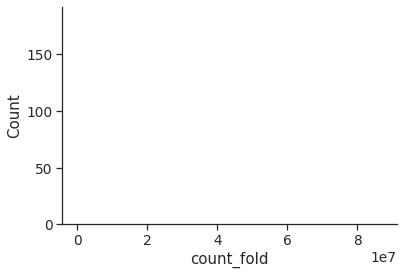

In [191]:
sns.histplot(data=df_all_counts_projects_fold['count_fold'])

<AxesSubplot:xlabel='genome_density', ylabel='Count'>

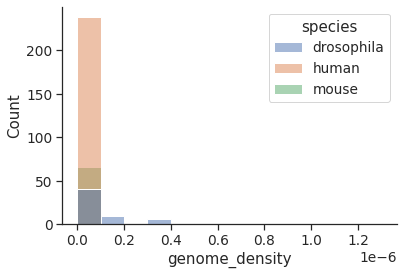

In [88]:
sns.histplot(data=df_all_counts_projects,  binwidth=.0000001, x='genome_density', hue='species')

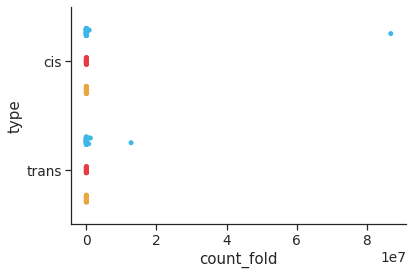

In [192]:
ax = sns.stripplot(y="type", x="count_fold", data=df_all_counts_projects_fold, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#3CB7E8', '#E83B43', '#E8A63B'])
#ax = sns.stripplot(y="type", x="genome_density", data=df_all_counts_projects_meta, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#3CB7E8', '#E83B43', '#E8A63B'])
ax.legend().remove()
#ax.set(xscale="log")

[None]

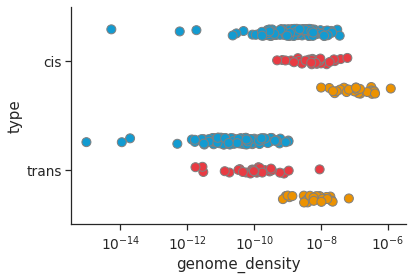

In [216]:
#ax = sns.stripplot(y="type", x="genome_density", data=df_all_counts_projects, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['lightcyan', 'mistyrose', 'antiquewhite'],edgecolor="grey", s=8, linewidth=1,)
ax = sns.stripplot(y="type", x="genome_density", data=df_all_counts_projects, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#129BD1', '#E83B43', '#EC9200'],edgecolor="grey", s=9, linewidth=1,)
#ax = sns.stripplot(y="type", x="genome_density", data=df_all_counts_projects_meta, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#129BD1', '#E83B43', '#EC9200'],edgecolor="grey", s=8, linewidth=1)
ax.legend().remove()
ax.set(xscale="log")
#import matplotlib.ticker as ticker
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(.00001))


#sns.boxplot(y="type", x="genome_density", data=df_all_counts_projects)


In [277]:
df_all_counts_projects[(df_all_counts_projects['type']=='trans') & (df_all_counts_projects['species']=='human')].sort_values('counts')



species    proj_id   type      counts  counts_log        genome_volume  \
206   human  SRP109036  trans        7568    3.878981  7818995446846638550   
258   human  SRP182670  trans       86434    4.936685  7818995446846638550   
187   human  SRP076397  trans      152670    5.183754  7818995446846638550   
198   human  SRP105086  trans     3947486    6.596321  7818995446846638550   
194   human  SRP100408  trans    10734504    7.030782  7818995446846638550   
..      ...        ...    ...         ...         ...                  ...   
215   human  SRP118999  trans  4477597526    9.651045  7818995446846638550   
235   human  SRP152879  trans  4717992990    9.673757  7818995446846638550   
236   human  SRP152979  trans  6886082828    9.837972  7818995446846638550   
182   human  SRP012412  trans  8197215080    9.913666  7818995446846638550   
183   human  SRP050102  trans  8302243136    9.919195  7818995446846638550   

     genome_density  genome_density_log  
206    9.678993e-16          -15.014170  
258    1.105436e-14          -13.956466  
187    1.952553e-14          -13.709397  
198    5.048585e-13          -12.296830  
194    1.372875e-12          -11.862369  
..              ...                 ...  
215    5.726564e-10           -9.242106  
235    6.034014e-10           -9.219394  
236    8.806864e-10           -9.055179  
182    1.048372e-09           -8.979485  
183    1.061804e-09           -8.973956  

[119 rows x 8 columns]

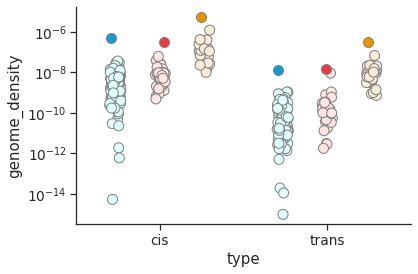

In [284]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)
import joypy
#plt.figure(figsize=(6,4))

ax = sns.stripplot(x="type", y="genome_density", data=df_all_counts_projects, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['lightcyan', 'mistyrose', 'antiquewhite'],edgecolor="grey", s=10, linewidth=1)
#ax = sns.stripplot(y="type", x="genome_density", data=df_all_counts_projects, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#129BD1', '#E83B43', '#EC9200'],edgecolor="grey", s=9, linewidth=1,)
ax = sns.stripplot(x="type", y="genome_density", data=df_all_counts_projects_meta, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#129BD1', '#E83B43', '#EC9200'],edgecolor="grey", s=10, linewidth=1)
#ax = sns.stripplot(x="type", y="genome_density", data=df_all_counts_projects, hue='type', dodge=True, palette=['white', 'dimgrey'],edgecolor="grey", s=10, linewidth=1, marker='$/$')

ax.legend().remove()
ax.set(yscale="log")
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/per_proj_seq_depth_density.pdf',
            transparent=True)
#import matplotlib.ticker as ticker
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(.00001))


#sns.boxplot(y="type", x="genome_density", data=df_all_counts_projects)


In [267]:
df_all_counts_projects.groupby(['species'])['counts'].sum()

species
drosophila     19357507413
human         304947368523
mouse         193574493860
Name: counts, dtype: int64

In [270]:
df_all_counts_projects.groupby(['species', 'type'])['counts'].sum()

species     type 
drosophila  cis       16618040587
            trans      2739466826
human       cis      208492043801
            trans     96455324722
mouse       cis      108163074666
            trans     85411419194
Name: counts, dtype: int64

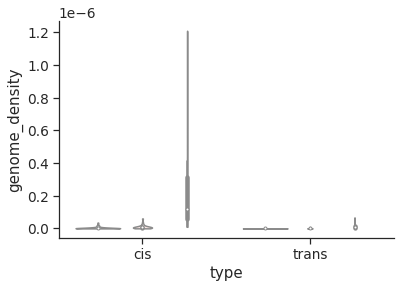

In [246]:
ax = sns.violinplot(x="type", y="genome_density", data=df_all_counts_projects, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['lightcyan', 'mistyrose', 'antiquewhite'],edgecolor="grey",  cut=0)
#ax = sns.stripplot(y="type", x="genome_density", data=df_all_counts_projects, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#129BD1', '#E83B43', '#EC9200'],edgecolor="grey", s=9, linewidth=1,)
#ax = sns.stripplot(x="type", y="genome_density", data=df_all_counts_projects_meta, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#129BD1', '#E83B43', '#EC9200'],edgecolor="grey", s=10, linewidth=1)
ax.legend().remove()
#ax.set(yscale="log")


In [229]:
a

NameError: name 'a' is not defined

[None]

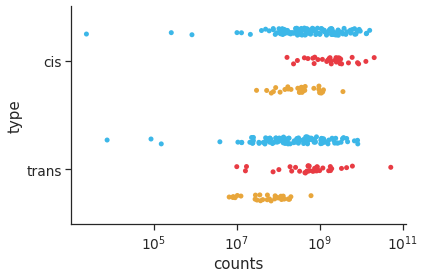

In [178]:
ax = sns.stripplot(y="type", x="counts", data=df_all_counts_projects, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#3CB7E8', '#E83B43', '#E8A63B'])
#ax = sns.stripplot(y="type", x="genome_density", data=df_all_counts_projects_meta, hue='species', dodge=True, hue_order=['human', 'mouse', 'drosophila'], palette=['#3CB7E8', '#E83B43', '#E8A63B'])
ax.legend().remove()
ax.set(xscale="log")
#import matplotlib.ticker as ticker
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(.00001))


#sns.boxplot(y="type", x="genome_density", data=df_all_counts_projects)

In [228]:
df_all_counts_projects

species    proj_id   type      counts  counts_log  \
0    drosophila  ERP016479    cis  1095110139    9.039458   
1    drosophila  ERP112723    cis    52975100    7.724072   
2    drosophila  ERP112882    cis   325091050    8.512005   
3    drosophila  ERP122732    cis  3648193480    9.562078   
4    drosophila  SRP050096    cis  1002845398    9.001234   
..          ...        ...    ...         ...         ...   
357       mouse  SRP255620  trans   532658360    8.726449   
358       mouse  SRP261290  trans  1827183488    9.261782   
359       mouse  SRP268173  trans   581117420    8.764264   
360       mouse  SRP270993  trans   561311230    8.749204   
361       mouse  SRP292639  trans    75510394    7.878007   

           genome_volume  genome_density  genome_density_log  
0       3013409580879291    3.634123e-07           -6.439600  
1       3013409580879291    1.757979e-08           -7.754986  
2       3013409580879291    1.078815e-07           -6.967053  
3       3013409580879291    1.210653e-06           -5.916980  
4       3013409580879291    3.327943e-07           -6.477824  
..                   ...             ...                 ...  
357  5726724633169315728    9.301274e-11          -10.031458  
358  5726724633169315728    3.190626e-10           -9.496124  
359  5726724633169315728    1.014747e-10           -9.993642  
360  5726724633169315728    9.801610e-11          -10.008703  
361  5726724633169315728    1.318562e-11          -10.879900  

[362 rows x 8 columns]

In [174]:
df_all = pd.concat([df_all_counts_projects, df_all_counts_projects_meta])

In [151]:
df_all_counts_projects_meta

species   type        counts  counts_log  species_dig  \
0       human    cis  208492043801   11.319089            0   
1       human  trans   96455324722   10.984326            0   
2       mouse    cis  108163074666   11.034079            1   
3       mouse  trans   85411419194   10.931516            1   
4  drosophila    cis   16618040587   10.220580            2   
5  drosophila  trans    2739466826    9.437666            2   

         genome_volume  genome_density  genome_density_log  
0   446638304655677934    4.668029e-07           -6.330866  
1  7818995446846638550    1.233603e-08           -7.908825  
2   338390139063593401    3.196401e-07           -6.495339  
3  5726724633169315728    1.491453e-08           -7.826390  
4     3013409580879291    5.514697e-06           -5.258478  
5     9161139031046278    2.990312e-07           -6.524283

In [153]:
df_all

species    proj_id   type        counts  counts_log  \
0   drosophila  ERP016479    cis    1095110139    9.039458   
1   drosophila  ERP112723    cis      52975100    7.724072   
2   drosophila  ERP112882    cis     325091050    8.512005   
3   drosophila  ERP122732    cis    3648193480    9.562078   
4   drosophila  SRP050096    cis    1002845398    9.001234   
..         ...        ...    ...           ...         ...   
1        human        NaN  trans   96455324722   10.984326   
2        mouse        NaN    cis  108163074666   11.034079   
3        mouse        NaN  trans   85411419194   10.931516   
4   drosophila        NaN    cis   16618040587   10.220580   
5   drosophila        NaN  trans    2739466826    9.437666   

          genome_volume  genome_density  genome_density_log  species_dig  
0      3013409580879291    3.634123e-07           -6.439600          NaN  
1      3013409580879291    1.757979e-08           -7.754986          NaN  
2      3013409580879291    1.078815e-07           -6.967053          NaN  
3      3013409580879291    1.210653e-06           -5.916980          NaN  
4      3013409580879291    3.327943e-07           -6.477824          NaN  
..                  ...             ...                 ...          ...  
1   7818995446846638550    1.233603e-08           -7.908825          0.0  
2    338390139063593401    3.196401e-07           -6.495339          1.0  
3   5726724633169315728    1.491453e-08           -7.826390          1.0  
4      3013409580879291    5.514697e-06           -5.258478          2.0  
5      9161139031046278    2.990312e-07           -6.524283          2.0  

[368 rows x 9 columns]

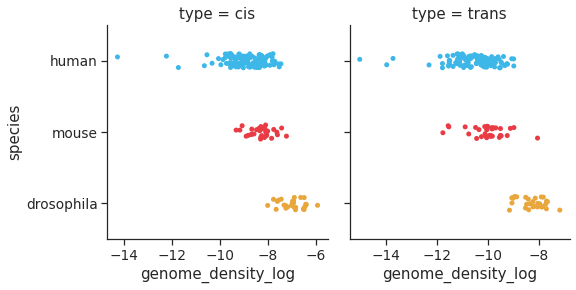

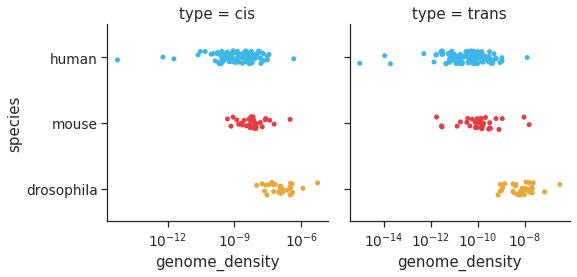

In [164]:
g = sns.catplot(y="species", x="genome_density_log", data=df_all_counts_projects, col='type', kind="strip",
                height=4, aspect=1, sharex=False, order=['human', 'mouse', 'drosophila'], palette=['#3CB7E8', '#E83B43', '#E8A63B'])
g = sns.catplot(y="species", x="genome_density", data=df_all, col='type', kind="strip",
                height=4, aspect=1, sharex=False, order=['human', 'mouse', 'drosophila'], palette=['#3CB7E8', '#E83B43', '#E8A63B'])
g.set(xscale="log")


In [ ]:
g = sns.catplot(y="type", x="genome_density", data=df_all_counts_projects, col='species', kind="strip",
                height=4, aspect=0.8, sharex=False, col_order=['human', 'mouse', 'drosophila'], palette=['#3CB7E8', '#E83B43', '#E8A63B'])
;

In [38]:
df_all_counts_projects_meta = df_all_counts_projects_meta.merge(df1)

NameError: name 'df_all_counts_projects_meta' is not defined

In [544]:
df_all_counts_projects_meta['genome_density'] = df_all_counts_projects_meta['counts'] / df_all_counts_projects_meta['genome_volume']

df_all_counts_projects_meta['genome_density_log'] = [np.log10(x) for x in df_all_counts_projects_meta['genome_density'] ]


In [140]:
df_all_counts_projects_meta = df_all_counts_projects_meta.merge(df1)
df_all_counts_projects_meta['genome_density'] = df_all_counts_projects_meta['counts'] / df_all_counts_projects_meta['genome_volume']

df_all_counts_projects_meta['genome_density_log'] = [np.log10(x) for x in df_all_counts_projects_meta['genome_density'] ]


In [548]:
df_all_counts_projects_meta

species   type        counts  counts_log  species_dig  \
0       human    cis  208492043801   11.319089            0   
1       human  trans   96455324722   10.984326            0   
2       mouse    cis  108163074666   11.034079            1   
3       mouse  trans   85411419194   10.931516            1   
4  drosophila    cis   16618040587   10.220580            2   
5  drosophila  trans    2739466826    9.437666            2   

         genome_volume  genome_density  genome_density_log  
0   446638304655677934    4.668029e-07           -6.330866  
1  7818995446846638550    1.233603e-08           -7.908825  
2   338390139063593401    3.196401e-07           -6.495339  
3  5726724633169315728    1.491453e-08           -7.826390  
4     3013409580879291    5.514697e-06           -5.258478  
5     9161139031046278    2.990312e-07           -6.524283

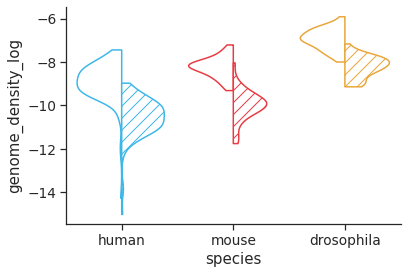

In [646]:
import matplotlib as mpl
markers = {"cis": "o", "trans": "X"}
#sns.scatterplot(data=df_all_counts_projects_meta, x='species', y='genome_density_log', style='type',s=60, legend=False, color='w', markers=markers, edgecolor='black', linewidth=2, hue='type')
sc_bar = sns.violinplot(data=df_all_counts_projects,  y='genome_density_log',x='species', order=['human', 'mouse', 'drosophila'], hue='type',split=True,  height=6, aspect=9/9.5, cut=0, palette=['white', 'white'], legend=False,dodge=True, inner=None)
#sc3 = sns.scatterplot(data=df_all_counts_projects_meta, x='species', y='genome_density_log', style='type',s=60, legend=False, color=['w'], markers=markers, edgecolor='black', hue='type')
#sc_swarm = sns.swarmplot(data=df_all_counts_projects_meta, x='species', y='genome_density_log', order=['human', 'mouse', 'drosophila'], hue='type',  palette=['white', 'black', 'red', 'green'],dodge=True, size=8, edgecolor='black', linewidth=1)
pattern=['','//', '','//', '','//']
violin_color = ['#3CB7E8', '#3CB7E8', '#E83B43', '#E83B43', '#E8A63B','#E8A63B']
violin_colors=iter(violin_color)
# replace 2 with 7 in your code
hatches=iter(pattern)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc_swarm.get_children() if isinstance(i, mpl.collections.PolyCollection)]


violin_colors=iter(violin_color)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]

_ = [i.set_hatch(next(hatches)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]
sc_bar.legend().remove()

plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/per_proj_seq_depth_density.pdf',
            transparent=True)


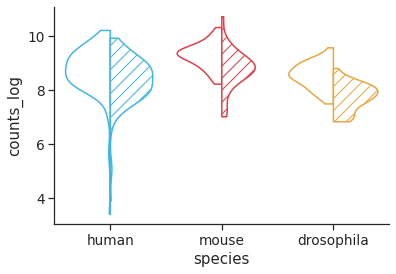

In [644]:
import matplotlib as mpl
markers = {"cis": "o", "trans": "X"}
#sns.scatterplot(data=df_all_counts_projects_meta, x='species', y='genome_density_log', style='type',s=60, legend=False, color='w', markers=markers, edgecolor='black', linewidth=2, hue='type')
sc_bar = sns.violinplot(data=df_all_counts_projects,  y='counts_log',x='species', order=['human', 'mouse', 'drosophila'], hue='type',split=True,  height=6, aspect=9/9.5, cut=0, palette=['white', 'white'], legend=False,dodge=True, inner=None)
#sc3 = sns.scatterplot(data=df_all_counts_projects_meta, x='species', y='counts_log', style='type',s=60, legend=False, color=['w'], markers=markers, edgecolor='black', hue='type')
#sc_swarm = sns.swarmplot(data=df_all_counts_projects_meta, x='species', y='counts_log', order=['human'], hue='type',  palette=['white', 'black', 'red', 'green'],dodge=True, size=8, edgecolor='black', linewidth=1)
pattern=['','//', '','//', '','//']
violin_color = ['#3CB7E8', '#3CB7E8', '#E83B43', '#E83B43', '#E8A63B','#E8A63B']
violin_colors=iter(violin_color)
# replace 2 with 7 in your code
hatches=iter(pattern)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc_swarm.get_children() if isinstance(i, mpl.collections.PolyCollection)]


violin_colors=iter(violin_color)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]

_ = [i.set_hatch(next(hatches)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]
sc_bar.legend().remove()

plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/per_proj_seq_depth.pdf',
            transparent=True)


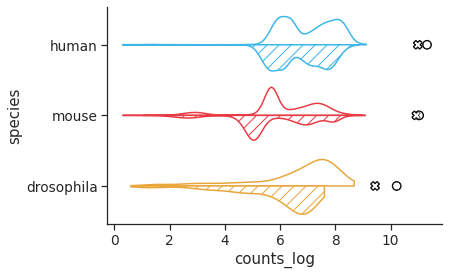

In [415]:
import matplotlib as mpl
sns.scatterplot(data=df_all_counts_projects_meta, y='species', x='counts_log', style='type',s=60, legend=False, color='w', markers=markers, edgecolor='black', linewidth=2)
sc_bar = sns.violinplot(data=df_all_counts,  x='counts_log',y='species', order=['human', 'mouse', 'drosophila'], hue='type',split=True,  height=6, aspect=9/9.5, cut=0, palette=['white', 'white'], legend=False,dodge=True, inner=None)

sc3 = sns.scatterplot(data=df_all_counts_projects_meta, y='species', x='counts_log', style='type',s=60, legend=False, color=['w'], markers=markers, edgecolor='black')
pattern=['','//', '','//', '','//']
violin_color = ['#3CB7E8', '#3CB7E8', '#E83B43', '#E83B43', '#E8A63B','#E8A63B']
violin_colors=iter(violin_color)
# replace 2 with 7 in your code
hatches=iter(pattern)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc3.get_children() if isinstance(i, mpl.collections.PolyCollection)]
violin_colors=iter(violin_color)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]

_ = [i.set_hatch(next(hatches)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]
sc_bar.legend().remove()
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/per_run_seq_depth.pdf',
            transparent=True)



In [611]:
df_total_runs_intra = df_intra.groupby(['species'])['run_id'].count().reset_index()
df_total_runs_intra['type'] = 'cis'

df_total_runs_inter = df_inter.groupby(['species'])['run_id'].count().reset_index()
df_total_runs_inter['type'] = 'trans'

df_total_runs = pd.concat([df_total_runs_intra, df_total_runs_inter])

#df_total_runs['run_id'] = [np.log10(x) for x in df_total_runs['run_id'] ]

In [612]:
df_total_runs_intra = df_intra.groupby(['species'])['proj_id'].nunique().reset_index()
df_total_runs_intra['type'] = 'cis'

df_total_runs_inter = df_inter.groupby(['species'])['proj_id'].nunique().reset_index()
df_total_runs_inter['type'] = 'trans'

df_total_projects = pd.concat([df_total_runs_intra, df_total_runs_inter])

#df_total_projects['proj_id'] = [np.log10(x) for x in df_total_projects['proj_id'] ]

In [613]:
df_total_runs_intra = df_intra.groupby(['species', 'proj_id'])['run_id'].count().reset_index()
df_total_runs_intra['type'] = 'cis'

df_total_runs_inter = df_inter.groupby(['species', 'proj_id'])['run_id'].count().reset_index()
df_total_runs_inter['type'] = 'trans'

df_total_runs_per_proj = pd.concat([df_total_runs_intra, df_total_runs_inter])

df_total_runs_per_proj['run_id_log'] = [np.log10(x) for x in df_total_runs_per_proj['run_id']]

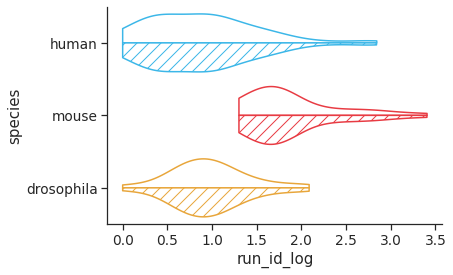

In [614]:
import matplotlib as mpl
sc_bar = sns.violinplot(data=df_total_runs_per_proj,  x='run_id_log',y='species', order=['human', 'mouse', 'drosophila'], hue='type',split=True,  height=6, aspect=9/9.5, cut=0, palette=['white', 'white'], legend=False,dodge=True,inner=None)


pattern=['','//', '','//', '','//']
violin_color = ['#3CB7E8', '#3CB7E8', '#E83B43', '#E83B43', '#E8A63B','#E8A63B']
violin_colors=iter(violin_color)
# replace 2 with 7 in your code
hatches=iter(pattern)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]

_ = [i.set_hatch(next(hatches)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]
sc_bar.legend().remove()
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/runs_per_proj.pdf',
            transparent=True)

No handles with labels found to put in legend.


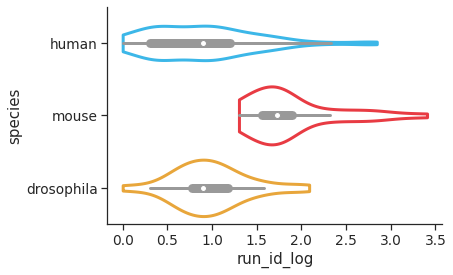

In [654]:
import matplotlib as mpl
sc_bar = sns.violinplot(data=df_total_runs_per_proj,  x='run_id_log',y='species', order=['human', 'mouse', 'drosophila'] , height=6, aspect=9/9.5, cut=0, palette=['white', 'white'], legend=False,dodge=True, edgecolor='black', linewidth=3)


pattern=['','//', '','//', '','//']
violin_color = ['#3CB7E8', '#E83B43', '#E8A63B']
violin_colors=iter(violin_color)
# replace 2 with 7 in your code
hatches=iter(pattern)
_ = [i.set_edgecolor(next(violin_colors)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]

#_ = [i.set_hatch(next(hatches)) for i in sc_bar.get_children() if isinstance(i, mpl.collections.PolyCollection)]
sc_bar.legend().remove()
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/runs_per_proj.pdf',
            transparent=True)

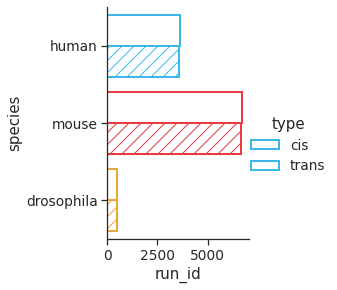

In [417]:
sc_bar = sns.catplot(data=df_total_runs, y='species', x='run_id', height=4, aspect=9/9.5, kind="bar", hue='type', order=['human', 'mouse', 'drosophila'], fill=False, edgecolor=['#3CB7E8', '#E83B43', '#E8A63B'], linewidth=2)
bars = sc_bar.axes.ravel()[0].patches

pattern=[' ','//']

# replace 2 with 7 in your code
hatches=np.repeat(pattern,3)

for pat,bar in zip(hatches,bars):
    bar.set_hatch(pat)
    
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/runs_per_species.pdf',
            transparent=True)

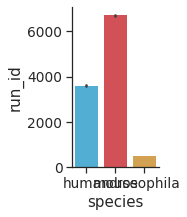

In [912]:
sc_bar = sns.catplot(data=df_total_runs, x='species', y='run_id', height=3, aspect=8/9.5, kind="bar", order=['human', 'mouse', 'drosophila'], fill=True, edgecolor=['black', 'black', 'black'], linewidth=0, palette=['#3CB7E8', '#E83B43', '#E8A63B'])
bars = sc_bar.axes.ravel()[0].patches

pattern=[' ','//']

# replace 2 with 7 in your code
hatches=np.repeat(pattern,3)

#for pat,bar in zip(hatches,bars):
#    bar.set_hatch(pat)
    
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/runs_per_species.pdf',
            transparent=True)

In [926]:
df_total_runs

species  run_id   type
0  drosophila     487    cis
1       human    3619    cis
2       mouse    6732    cis
0  drosophila     487  trans
1       human    3579  trans
2       mouse    6679  trans

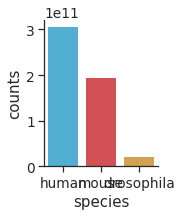

In [925]:
sc_bar = sns.catplot(data=df_all_counts_projects_meta.groupby('species')['counts'].sum().reset_index(), x='species', y='counts', height=3, aspect=8/9.5, kind="bar", order=['human', 'mouse', 'drosophila'], fill=True, edgecolor=['black', 'black', 'black'], linewidth=0, palette=['#3CB7E8', '#E83B43', '#E8A63B'])
bars = sc_bar.axes.ravel()[0].patches

pattern=[' ','//']

# replace 2 with 7 in your code
hatches=np.repeat(pattern,3)

#for pat,bar in zip(hatches,bars):
#    bar.set_hatch(pat)

In [924]:
df_all_counts_projects_meta.groupby('species')['counts'].sum().reset_index()

species        counts
0  drosophila   19357507413
1       human  304947368523
2       mouse  193574493860

In [917]:
df_all_counts_projects[df_all_counts_projects['species'] == 'human']

species    proj_id   type      counts  counts_log        genome_volume  \
58    human  DRP005173    cis   189959809    8.278662   446638304655677934   
59    human  DRP005280    cis   361836452    8.558512   446638304655677934   
60    human  ERP104251    cis   469216847    8.671374   446638304655677934   
61    human  ERP107279    cis  2792708016    9.446026   446638304655677934   
62    human  ERP118600    cis   669098393    8.825490   446638304655677934   
..      ...        ...    ...         ...         ...                  ...   
291   human  SRP264796  trans   106142904    8.025891  7818995446846638550   
292   human  SRP267107  trans   502487970    8.701126  7818995446846638550   
293   human  SRP271101  trans   462355800    8.664976  7818995446846638550   
294   human  SRP272124  trans    24488520    7.388963  7818995446846638550   
295   human  SRP274139  trans   134998720    8.130330  7818995446846638550   

     genome_density  genome_density_log  
58     4.253102e-10           -9.371294  
59     8.101331e-10           -9.091444  
60     1.050552e-09           -8.978582  
61     6.252728e-09           -8.203930  
62     1.498077e-09           -8.824466  
..              ...                 ...  
291    1.357501e-11          -10.867260  
292    6.426503e-11          -10.192025  
293    5.913238e-11          -10.228175  
294    3.131927e-12          -11.504188  
295    1.726548e-11          -10.762821  

[238 rows x 8 columns]

In [915]:
df_all_counts_projects_meta

species   type        counts  counts_log  species_dig  \
0       human    cis  208492043801   11.319089            0   
1       human  trans   96455324722   10.984326            0   
2       mouse    cis  108163074666   11.034079            1   
3       mouse  trans   85411419194   10.931516            1   
4  drosophila    cis   16618040587   10.220580            2   
5  drosophila  trans    2739466826    9.437666            2   

         genome_volume  genome_density  genome_density_log  
0   446638304655677934    4.668029e-07           -6.330866  
1  7818995446846638550    1.233603e-08           -7.908825  
2   338390139063593401    3.196401e-07           -6.495339  
3  5726724633169315728    1.491453e-08           -7.826390  
4     3013409580879291    5.514697e-06           -5.258478  
5     9161139031046278    2.990312e-07           -6.524283

In [784]:
df_total_runs

species  run_id   type
0  drosophila     487    cis
1       human    3619    cis
2       mouse    6732    cis
0  drosophila     487  trans
1       human    3579  trans
2       mouse    6679  trans

In [785]:
df_total_projects

species  proj_id   type
0  drosophila       29    cis
1       human      119    cis
2       mouse       33    cis
0  drosophila       29  trans
1       human      119  trans
2       mouse       33  trans

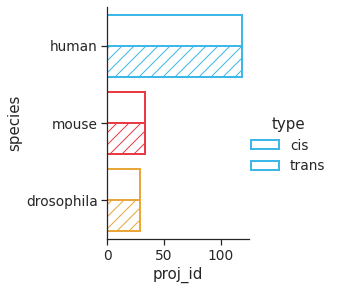

In [418]:
sc_bar = sns.catplot(data=df_total_projects, y='species', x='proj_id', height=4, aspect=9/9.5, kind="bar", hue='type', order=['human', 'mouse', 'drosophila'], fill=False, edgecolor=['#3CB7E8', '#E83B43', '#E8A63B'], linewidth=2)
bars = sc_bar.axes.ravel()[0].patches

pattern=[' ','//']

# replace 2 with 7 in your code
hatches=np.repeat(pattern,3)

for pat,bar in zip(hatches,bars):
    bar.set_hatch(pat)
    
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/projects_per_species.pdf',
            transparent=True)

#sc_bar.legend()
#splot.set(xscale="log")
#splot.set_xticks([20, 300, 500])
#splot.set_major_formatter(matplotlib.ticker.ScalarFormatter())

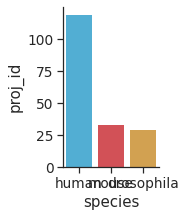

In [911]:
sc_bar = sns.catplot(data=df_total_projects, x='species', y='proj_id', height=3, aspect=8/9.5, kind="bar", order=['human', 'mouse', 'drosophila'], fill=True, edgecolor=['black', 'black', 'black'], linewidth=0, palette=['#3CB7E8', '#E83B43', '#E8A63B'])
bars = sc_bar.axes.ravel()[0].patches

pattern=[' ','//']

# replace 2 with 7 in your code
hatches=np.repeat(pattern,3)

for pat,bar in zip(hatches,bars):
    bar.set_hatch(pat)
    
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/projects_per_species.pdf',
            transparent=True)

In [ ]:
sc_bar = sns.catplot(data=df_total_projects, y='species', x='proj_id', height=4, aspect=9/9.5, kind="bar", hue='type', order=['human', 'mouse', 'drosophila'], fill=False, edgecolor=['#3CB7E8', '#E83B43', '#E8A63B'], linewidth=2)
bars = sc_bar.axes.ravel()[0].patches

pattern=[' ','//']

# replace 2 with 7 in your code
hatches=np.repeat(pattern,3)

for pat,bar in zip(hatches,bars):
    bar.set_hatch(pat)
    
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/projects_per_species.pdf',
            transparent=True)

#sc_bar.legend()
#splot.set(xscale="log")
#splot.set_xticks([20, 300, 500])
#splot.set_major_formatter(matplotlib.ticker.ScalarFormatter())

In [ ]:
sns.catplot(data=df_whole[df_whole['P_val_agg'] <= 0.04].sort_values(['X.2', 'P_val_agg']), y='X.1', x='P_val_agg_log', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False)
plt.savefig('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/GO_human_10kbp_trans.pdf',
            transparent=True)